# Import Libraries

In [35]:
import re
import string
import logging
import numpy as np
import pandas as pd
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, \
                                    Bidirectional, Add, Input, \
                                    MultiHeadAttention, LayerNormalization, \
                                    GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_recall_curve, \
                            accuracy_score, hamming_loss, precision_score, \
                            recall_score, f1_score, confusion_matrix, \
                            fbeta_score

# Configure Logging and GPU Usage

In [3]:
# Logging setup
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s', force=True)

def configure_gpu():
    """
    Configure TensorFlow to use GPU memory efficiently.
    """
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        try:
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            logging.info(f"{len(gpus)} GPU(s) configured for memory growth.")
        except RuntimeError as e:
            logging.error(f"Error configuring GPU memory growth: {e}")
    else:
        logging.warning("No GPU detected. Using CPU.")

configure_gpu()

2025-03-18 22:45:38,127 - WARNING - No GPU detected. Using CPU.


# Dataset Preprocessing


## Set Variables

In [8]:
# Set variables
DATASET_PATH = 'Datasets/essays.csv'
GLOVE_PATH = 'Datasets/glove.6B.100d.txt'
LABEL_MAPPING = {
    'cEXT': 'Extraversion',
    'cNEU': 'Neuroticism',
    'cAGR': 'Agreeableness',
    'cCON': 'Conscientiousness',
    'cOPN': 'Openness'
}
EMBEDDING_DIM = 100

## Load and Clean Data

In [11]:
# Proprocess dataset and extract text and labels.
def preprocess_text(text):
    """
    Clean and preprocess raw text data.

    Parameters
    ----------
      - text (str): Raw text.

    Returns
    -------
      - text (str): Cleaned text, converted to lowercase, with punctuation, numbers, and special characters removed.
    """
    text = text.lower() # Lowercase text
    text = re.sub(f"[{string.punctuation}]", "", text) # Remove punctuation
    text = re.sub(r"\d+", "", text) # Remove digits
    text = re.sub(r"http\S+|www\S+", "", text) # Remove urls
    text = re.sub(r"[^a-zA-Z\s]", "", text) # Remove non alphabetic characters
    text = tf.keras.preprocessing.text.text_to_word_sequence(text)
    return ' '.join(text)


def load_and_preprocess_data(file_path, label_mapping):
    """
    Load and preprocess dataset.

    Parameters
    ----------
      - file_path (str): Path of dataset.
      - label_mapping (dict): Mapping with full names
    Returns
    -------
      - dataset (pandas.core.frame.DataFrame): Dataset with cleaned text and renamed label columns.
      - texts (numpy.ndarray): Preprocessed text strings.
      - labels (numpy.ndarray): Binary label matrix.
    """
    logging.info("Loading dataset...")
    dataset = pd.read_csv(file_path, encoding='ISO-8859-1')

    logging.info("Preprocessing text data...")
    dataset['TEXT'] = dataset['TEXT'].apply(preprocess_text)

    # Rename columns and map labels
    dataset = dataset.rename(columns=label_mapping)
    for col in label_mapping.values():
        dataset[col] = dataset[col].map({'y': 1, 'n': 0})

    # Extract texts and labels
    texts = dataset['TEXT'].values
    labels = dataset[list(label_mapping.values())].values.astype('float32')

    return dataset, texts, labels

dataset, texts, labels = load_and_preprocess_data(DATASET_PATH, LABEL_MAPPING)
logging.info("Extracted Data with success.")

2025-03-18 22:45:48,324 - INFO - Loading dataset...
2025-03-18 22:45:48,377 - INFO - Preprocessing text data...
2025-03-18 22:45:48,699 - INFO - Extracted Data with success.


## Tokenize and Pad Sequences

In [14]:
def tokenize_and_pad_sequences(texts, percentile=90):
    """
    Tokenize text and pad sequences.

    Parameters
    ----------
      - texts (numpy.ndarray): List of preprocessed text strings.
      - percentile (int, optional): Percentile to determine maximum sequence length for padding (Default 90).

    Returns
    -------
      - tokenizer (keras.src.legacy.preprocessing.text.Tokenizer): Keras tokenizer object.
      - padded_sequences (numpy.ndarray): Tokenized and padded sequences.
      - vocab_size (int): Size of the vocabulary.
      - max_seq_len (int): Maximum sequence length.
    """
    logging.info("Tokenizing and padding sequences...")

    tknzr = Tokenizer()
    tknzr.fit_on_texts(texts)
    sequences = tknzr.texts_to_sequences(texts)
    # Compute maximum sequence length
    sequence_lengths = [len(seq) for seq in sequences]
    max_seq_len = int(np.percentile(sequence_lengths, percentile))
    # Pad sequences
    padded_sequences = pad_sequences(sequences, maxlen=max_seq_len, padding='post')

    # Adjust token indices: convert from 1-indexed to 0-indexed.
    # Leave padding (0) unchanged, subtract 1 from all nonzero tokens.
    padded_sequences = np.where(padded_sequences != 0, padded_sequences - 1, 0)
    
    # Compute vocabulary length
    vocab_size = len(tknzr.word_index)

    logging.info(f"Maximum sequence length: {max_seq_len}")
    logging.info(f"Vocabulary size: {vocab_size}")

    return tknzr, padded_sequences, vocab_size, max_seq_len

tokenizer, padded_sequences, vocab_size, max_seq_len = tokenize_and_pad_sequences(texts)

2025-03-18 22:45:55,208 - INFO - Tokenizing and padding sequences...
2025-03-18 22:45:55,925 - INFO - Maximum sequence length: 971
2025-03-18 22:45:55,925 - INFO - Vocabulary size: 31255


## Split Dataset


In [17]:
# Train/Test Split
X_train, X_temp, y_train, y_temp = train_test_split(padded_sequences, labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
logging.info("Dataset was split with success (70/15/15).")

2025-03-18 22:46:02,188 - INFO - Dataset was split with success (70/15/15).


# Word2Vec Embeddings

In [20]:
def train_word2vec_embeddings(sentences, embedding_dim=100, window=5, min_count=1, workers=4):
    """
    Train Word2Vec embeddings on tokenized sentences.

    Parameters
    ----------
      - sentences (list): Tokenized sentences.
      - embedding_dim (int, optional): Dimensionality of the word vectors (Default 100).
      - window (int, optional): Maximum distance between current and predicted word (Default 5).
      - min_count (int, optional): Frequency to ignore (Default 1).
      - workers (int, optional): Number of worker threads (Default 4).

    Returns
    -------
      - word2vec_model (gensim.models.word2vec.Word2Vec): Trained Word2Vec model.
    """
    logging.info("Training Word2Vec embeddings...")
    word2vec_model = Word2Vec(sentences, vector_size=embedding_dim, window=window, min_count=min_count, workers=workers)
    logging.info("Word2Vec embeddings training complete.")

    return word2vec_model

def build_embedding_matrix_word2vec(model, word_index, vocab_size, embedding_dim):
    """
    Build embedding matrix using a Word2Vec model.

    Input:
      - model (gensim.models.word2vec.Word2Vec): Word2Vec model.
      - word_index (dict): Word-to-index mapping.
      - vocab_size (int): Vocabulary size.
      - embedding_dim (int): Embedding dimensionality.

    Output:
      - embedding_matrix (numpy.ndarray): Embedding matrix.
    """
    logging.info("Building embedding matrix from Word2Vec...")
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    hits, misses = 0, 0

    for word, i in word_index.items():
        if i < vocab_size:
            vector = model.wv.get_vector(word) if word in model.wv else None
            if vector is not None:
                embedding_matrix[i] = vector
                hits += 1
            else:
                misses += 1

    logging.info(f"Converted {hits} words ({misses} misses) into embedding matrix.")
    return embedding_matrix

# Train Word2Vec Embeddings
tokenized_sentences = [text.split() for text in texts]
word2vec_model = train_word2vec_embeddings(tokenized_sentences, embedding_dim=EMBEDDING_DIM)

# Build Embedding Matrix
embedding_matrix_w2v = build_embedding_matrix_word2vec(
    word2vec_model, tokenizer.word_index, vocab_size, EMBEDDING_DIM
)

2025-03-18 22:46:07,892 - INFO - Training Word2Vec embeddings...
2025-03-18 22:46:07,893 - INFO - collecting all words and their counts
2025-03-18 22:46:07,893 - INFO - PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2025-03-18 22:46:08,016 - INFO - collected 31255 word types from a corpus of 1599259 raw words and 2468 sentences
2025-03-18 22:46:08,017 - INFO - Creating a fresh vocabulary
2025-03-18 22:46:08,082 - INFO - Word2Vec lifecycle event {'msg': 'effective_min_count=1 retains 31255 unique words (100.00% of original 31255, drops 0)', 'datetime': '2025-03-18T22:46:08.082545', 'gensim': '4.3.3', 'python': '3.10.13 | packaged by Anaconda, Inc. | (main, Sep 11 2023, 13:15:57) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.26100-SP0', 'event': 'prepare_vocab'}
2025-03-18 22:46:08,082 - INFO - Word2Vec lifecycle event {'msg': 'effective_min_count=1 leaves 1599259 word corpus (100.00% of original 1599259, drops 0)', 'datetime': '2025-03-18T22:46:08.082545'

# GloVe Embeddings

In [23]:
def load_glove_embeddings(file, word_index, vocab_size, embedding_dim=100):
    """
    Load pre-trained GloVe embeddings and create an embedding matrix.

    Parameters
    ----------
      - file (str): Path to GloVe embeddings file.
      - word_index (dict): Word-to-index mapping.
      - vocab_size (int): Maximum vocabulary size.
      - embedding_dim (int, optional): Dimensionality of the GloVe vectors (Default 100).

    Returns
    -------
      - embedding_matrix (numpy.ndarray): Matrix of word embeddings.
    """
    logging.info("Loading pretrained GloVe embeddings...")
    embedding_index = {}
    with open(file, encoding='utf8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            embedding_index[word] = vector

    # Build embedding matrix
    logging.info("Building embedding matrix...")
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    hits, misses = 0, 0
    for word, i in word_index.items():
        if i < vocab_size:
            vector = embedding_index.get(word)
            if vector is not None:
                embedding_matrix[i] = vector
                hits += 1
            else:
                misses += 1
    logging.info(f"Converted {hits} words ({misses} misses).")

    return embedding_matrix

# Load Embeddings
embedding_matrix_GloVe = load_glove_embeddings(GLOVE_PATH, tokenizer.word_index, vocab_size, EMBEDDING_DIM)

2025-03-18 22:46:18,921 - INFO - Loading pretrained GloVe embeddings...
2025-03-18 22:46:23,910 - INFO - Building embedding matrix...
2025-03-18 22:46:23,937 - INFO - Converted 23057 words (8197 misses).


# LSTM Model

## Define Basic Functions

In [27]:
def build_LSTM_model(embedding_matrix, embedding_dim, vocab_size):
    """
    Build and compile an LSTM-based model for multi-label classification.

    Parameters
    ----------
      - embedding_matrix (numpy.ndarray): Embedding matrix.
      - embedding_dim (int): Dimensionality of word embeddings.
      - vocab_size (int): Size of vocabulary.

    Returns
    -------
      - model (keras.src.models.sequential.Sequential): Keras model.
    """
    logging.info("Building LSTM model...")
    model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix],
              trainable=False),
    Bidirectional(LSTM(128, return_sequences=True)),
    Dropout(0.5),
    Bidirectional(LSTM(64)),
    Dropout(0.5),
    Dense(5, activation='sigmoid', kernel_regularizer=l2(0.01))
    ])

    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    return model

# Plot Training History
def plot_training_history(history):
    """
    Plot train history of accuracy and validation for train and validation sets.
    """
    plt.figure(figsize=(12, 5))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

def train_model(model, X_train, y_train, X_val, y_val, epochs, batch_size):
    """
    Train the LSTM model with training and validation data.

    Parameters
    ----------
      - model (keras.src.models.sequential.Sequential): Keras model.
      - X_train (numpy.ndarray): Training input sequences.
      - y_train (numpy.ndarray): Training labels.
      - X_val (numpy.ndarray): Validation input sequences.
      - y_val (numpy.ndarray): Validation labels.
      - epochs (int): Number of training epochs.
      - batch_size (int): Size of batch.

    Returns
    -------
      - history (keras.src.callbacks.history.History): Training history object.
    """
    logging.info("Training model...")

    callbacks = [
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)
    ]
    history = model.fit(
        X_train, y_train, validation_data=(X_val, y_val),
        epochs=epochs, batch_size=batch_size, callbacks=callbacks
    )

    return history

def evaluate_model(model, X_test, y_test, label_names):
    """
    Evaluate model on test dataset and print metrics.

    Parameters
    ----------
      - model (keras.models.Sequential): Keras model.
      - X_test (numpy.ndarray): Test input sequences.
      - y_test (numpy.ndarray): Test labels.
      - label_names (list or array): Full names of labels.
    """
    import numpy as np
    import logging
    import matplotlib.pyplot as plt
    import seaborn as sns
    from sklearn.metrics import (accuracy_score, hamming_loss, precision_score,
                                 recall_score, f1_score, classification_report,
                                 confusion_matrix)
    
    logging.info("Evaluating model...")
    y_pred_probs = model.predict(X_test)  # Predicted probabilities

    # Set the optimal threshold for all labels to 0.5.
    optimal_thresholds = [0.5] * y_test.shape[1]
    logging.info(f"Optimal thresholds for each label: {optimal_thresholds}")

    # Apply the fixed threshold to each label.
    y_pred = np.array([
        (y_pred_probs[:, i] >= optimal_thresholds[i]).astype(int)
        for i in range(y_test.shape[1])
    ]).T

    # Calculate Metrics.
    total_accuracy = accuracy_score(y_test, y_pred)
    multilabel_accuracy = 1 - hamming_loss(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    weighted_f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
    micro_f1 = f1_score(y_test, y_pred, average='micro', zero_division=0)
    macro_f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)
    
    logging.info(
        f"Total Accuracy: {total_accuracy:.4f}, "
        f"Multilabel Accuracy: {multilabel_accuracy:.4f}, "
        f"Weighted Precision: {precision:.4f}, "
        f"Weighted Recall: {recall:.4f}, "
        f"Weighted F1-Score: {weighted_f1:.4f}, "
        f"Micro F1-Score: {micro_f1:.4f}, "
        f"Macro F1-Score: {macro_f1:.4f}"
    )

    # Print the classification report.
    print(classification_report(y_test, y_pred, target_names=label_names, zero_division=0))

    # Plot Confusion Matrices.
    fig, axes = plt.subplots(1, len(label_names), figsize=(20, 5))
    for i, label in enumerate(label_names):
        cm = confusion_matrix(y_test[:, i], y_pred[:, i])
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[i])
        axes[i].set_title(f'{label}')
        axes[i].set_xlabel('Predicted')
        axes[i].set_ylabel('Actual')
    plt.tight_layout()
    plt.show()

## LSTM using Word2Vec

### Build Model

In [32]:
model_LSTM_w2v = build_LSTM_model(embedding_matrix_w2v, EMBEDDING_DIM, vocab_size)
model_LSTM_w2v.summary()

2025-03-18 19:37:37,403 - INFO - Building LSTM model...


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 100)         3125500   
                                                                 
 bidirectional (Bidirectiona  (None, None, 256)        234496    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, None, 256)         0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              164352    
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense (Dense)               (None, 5)                 6

### Train Model

2025-03-18 19:44:54,200 - INFO - Training model...


Epoch 1/500
27/27 [==============================] - 108s 4s/step - loss: 0.7464 - accuracy: 0.3109 - val_loss: 0.7419 - val_accuracy: 0.1432 - lr: 0.0010
Epoch 2/500
27/27 [==============================] - 105s 4s/step - loss: 0.7245 - accuracy: 0.1801 - val_loss: 0.7306 - val_accuracy: 0.1892 - lr: 0.0010
Epoch 3/500
27/27 [==============================] - 105s 4s/step - loss: 0.7070 - accuracy: 0.1882 - val_loss: 0.7226 - val_accuracy: 0.1432 - lr: 0.0010
Epoch 4/500
27/27 [==============================] - 105s 4s/step - loss: 0.6909 - accuracy: 0.2444 - val_loss: 0.7230 - val_accuracy: 0.1595 - lr: 0.0010
Epoch 5/500
27/27 [==============================] - 105s 4s/step - loss: 0.6766 - accuracy: 0.2113 - val_loss: 0.7201 - val_accuracy: 0.0865 - lr: 0.0010
Epoch 6/500
27/27 [==============================] - 105s 4s/step - loss: 0.6620 - accuracy: 0.2067 - val_loss: 0.7253 - val_accuracy: 0.0973 - lr: 0.0010
Epoch 7/500
27/27 [==============================] - 105s 4s/step - lo

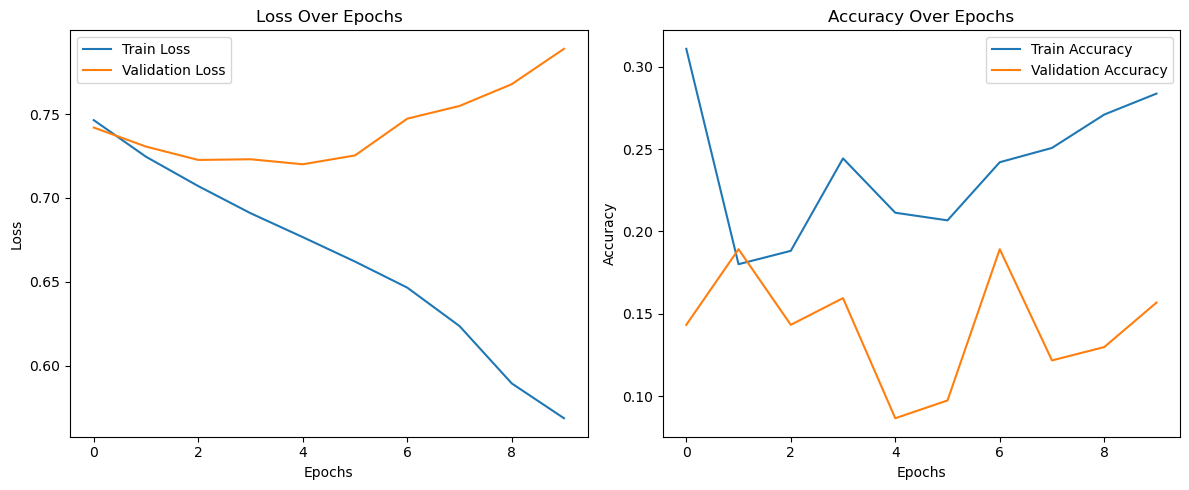

In [39]:
lstm_model_w2v_train_history = train_model(model_LSTM_w2v, X_train, y_train, X_val, y_val, 500, 64) # Train Model
plot_training_history(lstm_model_w2v_train_history)

# Save the trained model
model_LSTM_w2v.save("model_LSTM_w2v.h5")

### Evaluate Model

2025-03-18 20:54:51,554 - INFO - Evaluating model...


12/12 [==============================] - 12s 795ms/step


2025-03-18 20:55:03,715 - INFO - Optimal thresholds for each label: [0.5, 0.5, 0.5, 0.5, 0.5]
2025-03-18 20:55:03,731 - INFO - Total Accuracy: 0.0485, Multilabel Accuracy: 0.5154, Weighted Precision: 0.5422, Weighted Recall: 0.5799, Weighted F1-Score: 0.5509, Micro F1-Score: 0.5574, Macro F1-Score: 0.5507


                   precision    recall  f1-score   support

     Extraversion       0.60      0.46      0.52       213
      Neuroticism       0.50      0.44      0.47       176
    Agreeableness       0.53      0.77      0.63       193
Conscientiousness       0.56      0.52      0.54       211
         Openness       0.50      0.72      0.59       183

        micro avg       0.54      0.58      0.56       976
        macro avg       0.54      0.58      0.55       976
     weighted avg       0.54      0.58      0.55       976
      samples avg       0.53      0.57      0.51       976



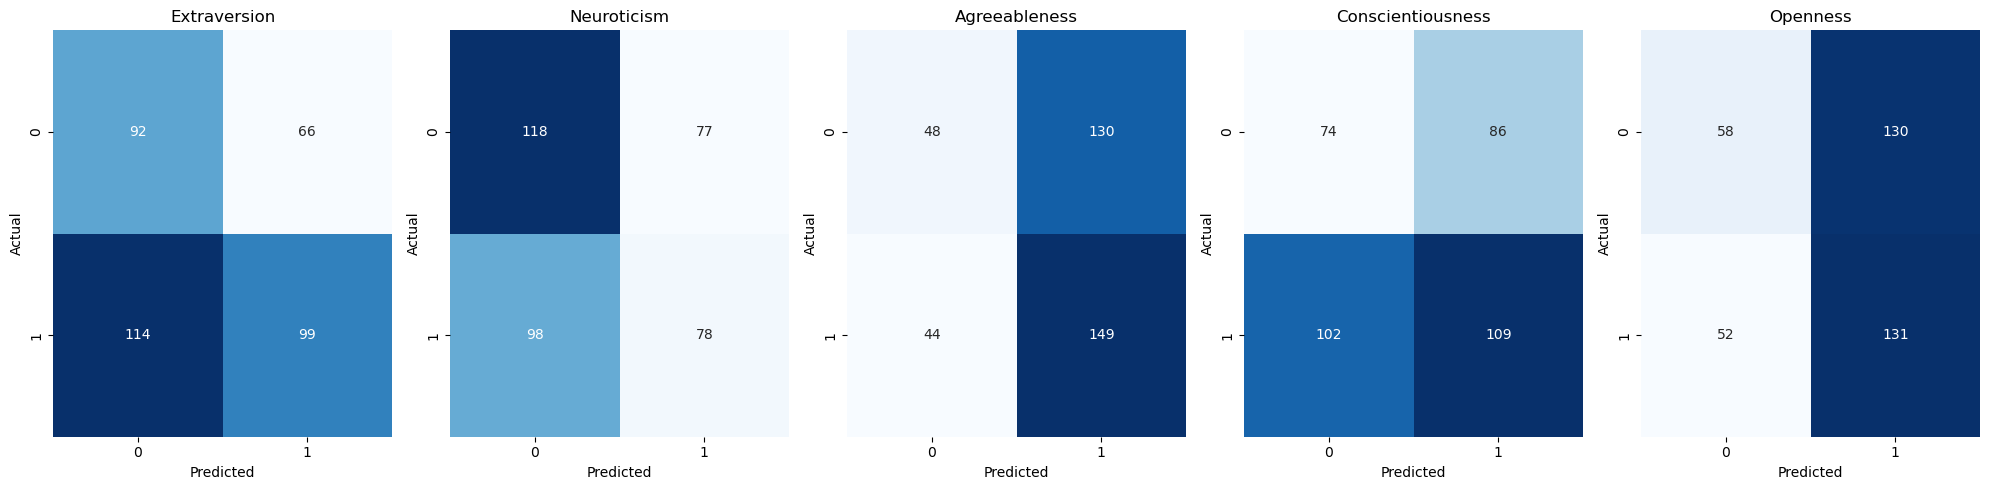

In [65]:
# Load the saved model
model_LSTM_w2v = load_model("model_LSTM_w2v.h5")
evaluate_model(model_LSTM_w2v, X_test, y_test, LABEL_MAPPING.values()) # Evaluate Model

## LSTM using GloVe

### Build Model

In [43]:
model_LSTM_GloVe = build_LSTM_model(embedding_matrix_GloVe, EMBEDDING_DIM, vocab_size) # Build Model
model_LSTM_GloVe.summary()

2025-03-18 20:14:28,522 - INFO - Building LSTM model...


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 100)         3125500   
                                                                 
 bidirectional_2 (Bidirectio  (None, None, 256)        234496    
 nal)                                                            
                                                                 
 dropout_2 (Dropout)         (None, None, 256)         0         
                                                                 
 bidirectional_3 (Bidirectio  (None, 128)              164352    
 nal)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 5)                

### Train Model

2025-03-18 20:14:37,657 - INFO - Training model...


Epoch 1/500
27/27 [==============================] - 107s 4s/step - loss: 0.7864 - accuracy: 0.1824 - val_loss: 0.7657 - val_accuracy: 0.1595 - lr: 0.0010
Epoch 2/500
27/27 [==============================] - 105s 4s/step - loss: 0.7557 - accuracy: 0.2177 - val_loss: 0.7450 - val_accuracy: 0.2324 - lr: 0.0010
Epoch 3/500
27/27 [==============================] - 103s 4s/step - loss: 0.7375 - accuracy: 0.1616 - val_loss: 0.7295 - val_accuracy: 0.1162 - lr: 0.0010
Epoch 4/500
27/27 [==============================] - 106s 4s/step - loss: 0.7236 - accuracy: 0.2096 - val_loss: 0.7186 - val_accuracy: 0.2297 - lr: 0.0010
Epoch 5/500
27/27 [==============================] - 104s 4s/step - loss: 0.7129 - accuracy: 0.1552 - val_loss: 0.7106 - val_accuracy: 0.2000 - lr: 0.0010
Epoch 6/500
27/27 [==============================] - 112s 4s/step - loss: 0.7044 - accuracy: 0.1563 - val_loss: 0.7049 - val_accuracy: 0.1216 - lr: 0.0010
Epoch 7/500
27/27 [==============================] - 115s 4s/step - lo

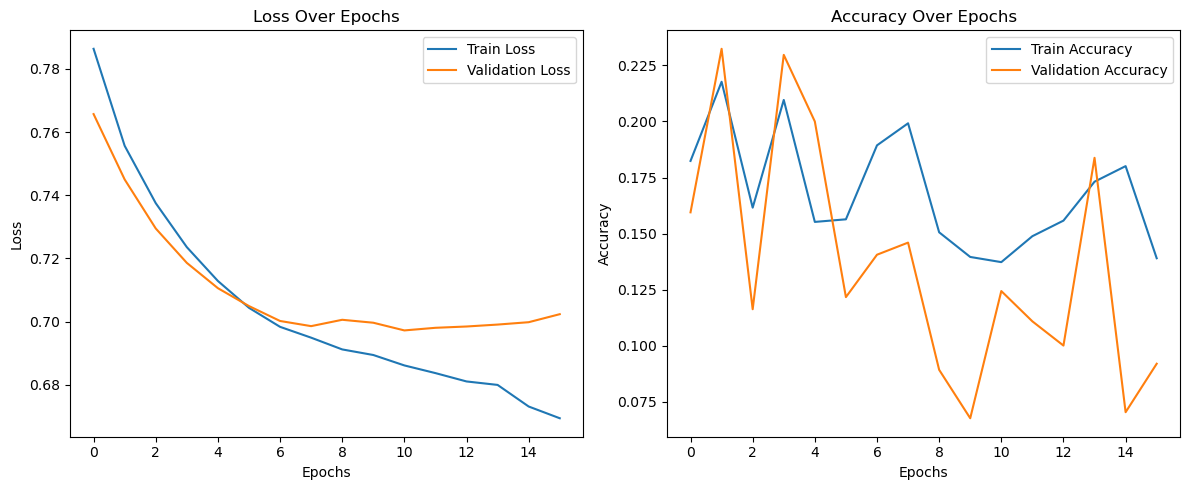

In [45]:
lstm_model_GloVe_train_history = train_model(model_LSTM_GloVe, X_train, y_train, X_val, y_val, 500, 64) # Train Model
plot_training_history(lstm_model_GloVe_train_history) # Plot train history

# Save the trained model
model_LSTM_GloVe.save("model_LSTM_GloVe.h5")

### Evaluate Model

2025-03-18 20:55:51,108 - INFO - Evaluating model...


12/12 [==============================] - 11s 796ms/step


2025-03-18 20:56:02,541 - INFO - Optimal thresholds for each label: [0.5, 0.5, 0.5, 0.5, 0.5]
2025-03-18 20:56:02,557 - INFO - Total Accuracy: 0.0512, Multilabel Accuracy: 0.5235, Weighted Precision: 0.5752, Weighted Recall: 0.5123, Weighted F1-Score: 0.5129, Micro F1-Score: 0.5308, Macro F1-Score: 0.5147


                   precision    recall  f1-score   support

     Extraversion       0.59      0.62      0.60       213
      Neuroticism       0.49      0.51      0.50       176
    Agreeableness       0.57      0.42      0.49       193
Conscientiousness       0.69      0.25      0.36       211
         Openness       0.51      0.80      0.62       183

        micro avg       0.55      0.51      0.53       976
        macro avg       0.57      0.52      0.51       976
     weighted avg       0.58      0.51      0.51       976
      samples avg       0.54      0.49      0.48       976



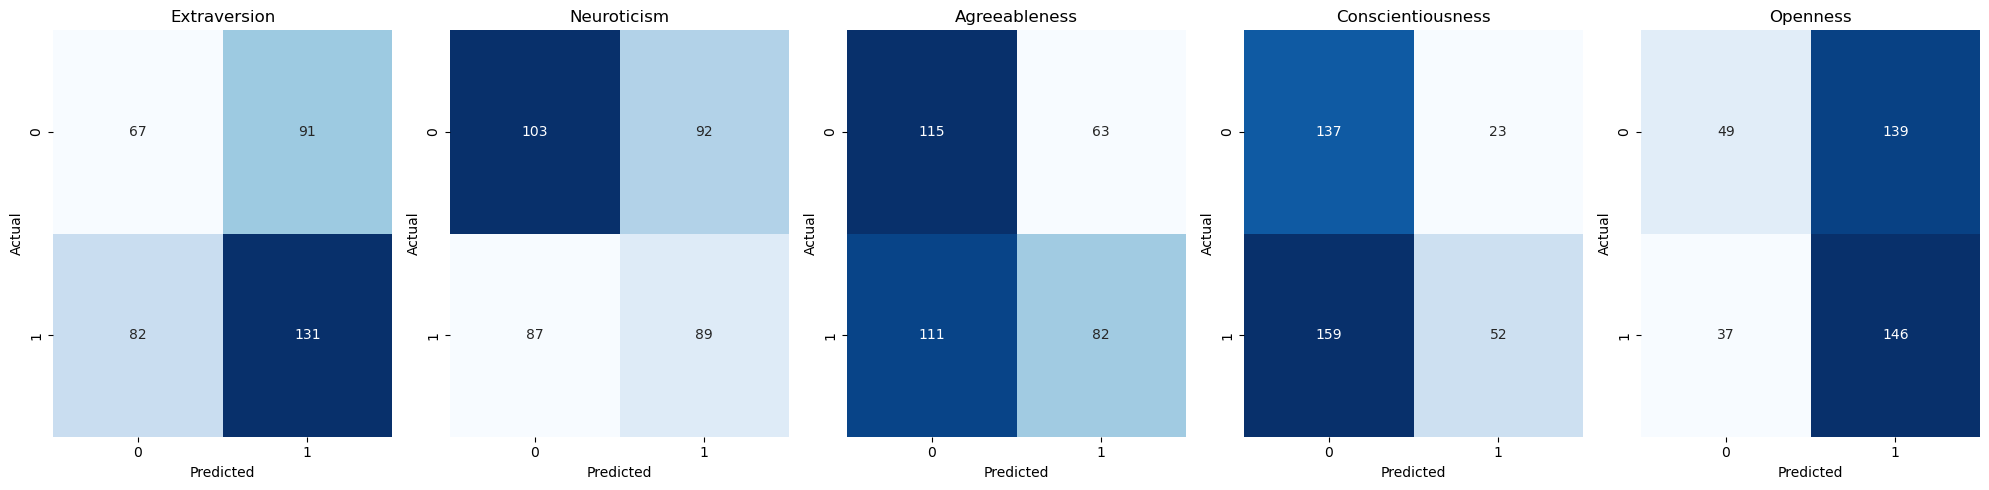

In [67]:
# Load the saved model
model_LSTM_GloVe = load_model("model_LSTM_GloVe.h5")
evaluate_model(model_LSTM_GloVe, X_test, y_test, LABEL_MAPPING.values()) # Evaluate Model

# Transformer Model

## Build Model

In [29]:
def build_transformer_model(vocab_size, embedding_dim, embedding_matrix, max_len, num_labels):
    """
    Build transformer-based model using embeddings for multi-label classification.

    Parameters
    ----------
      - vocab_size (int): Vocabulary size.
      - embedding_dim (int): Dimension of embeddings.
      - embedding_matrix (numpy.ndarray): Pre-trained embedding matrix.
      - max_len (int): Maximum sequence length.
      - num_labels (int): Number of output labels.

    Returns
    -------
      - model (keras.src.models.functional.Functional): Compiled model.
    """
    logging.info("Building Transformer...")
    inputs = Input(shape=(max_len,))
    embedding_layer = Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        weights=[embedding_matrix],
        input_length=max_len,
        trainable=False
    )(inputs)

    attention_output = MultiHeadAttention(num_heads=4, key_dim=embedding_dim)(embedding_layer, embedding_layer)
    attention_output = Add()([embedding_layer, attention_output])
    attention_output = LayerNormalization()(attention_output)

    dense_output = Dense(128, activation='relu')(attention_output)
    dense_output = GlobalAveragePooling1D()(dense_output)
    outputs = Dense(num_labels, activation='sigmoid')(dense_output)

    model = Model(inputs=inputs, outputs=outputs)

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    return model

model_transformer = build_transformer_model(vocab_size, EMBEDDING_DIM, embedding_matrix_w2v, max_seq_len, len(LABEL_MAPPING))
model_transformer.summary()

2025-03-18 22:46:46,203 - INFO - Building Transformer...


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 971)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 971, 100)     3125500     ['input_1[0][0]']                
                                                                                                  
 multi_head_attention (MultiHea  (None, 971, 100)    161300      ['embedding[0][0]',              
 dAttention)                                                      'embedding[0][0]']              
                                                                                                  
 add (Add)                      (None, 971, 100)     0           ['embedding[0][0]',          

## Train Model

Epoch 1/500
27/27 [==============================] - 42s 2s/step - loss: 0.7019 - accuracy: 0.1743 - val_loss: 0.6965 - val_accuracy: 0.2838 - lr: 0.0010
Epoch 2/500
27/27 [==============================] - 44s 2s/step - loss: 0.6927 - accuracy: 0.2189 - val_loss: 0.6929 - val_accuracy: 0.1324 - lr: 0.0010
Epoch 3/500
27/27 [==============================] - 44s 2s/step - loss: 0.6892 - accuracy: 0.2866 - val_loss: 0.6948 - val_accuracy: 0.1784 - lr: 0.0010
Epoch 4/500
27/27 [==============================] - 43s 2s/step - loss: 0.6924 - accuracy: 0.2125 - val_loss: 0.6893 - val_accuracy: 0.1405 - lr: 0.0010
Epoch 5/500
27/27 [==============================] - 43s 2s/step - loss: 0.6864 - accuracy: 0.1859 - val_loss: 0.6893 - val_accuracy: 0.2811 - lr: 0.0010
Epoch 6/500
27/27 [==============================] - 44s 2s/step - loss: 0.6823 - accuracy: 0.2015 - val_loss: 0.6969 - val_accuracy: 0.0568 - lr: 0.0010
Epoch 7/500
27/27 [==============================] - 43s 2s/step - loss: 0.6

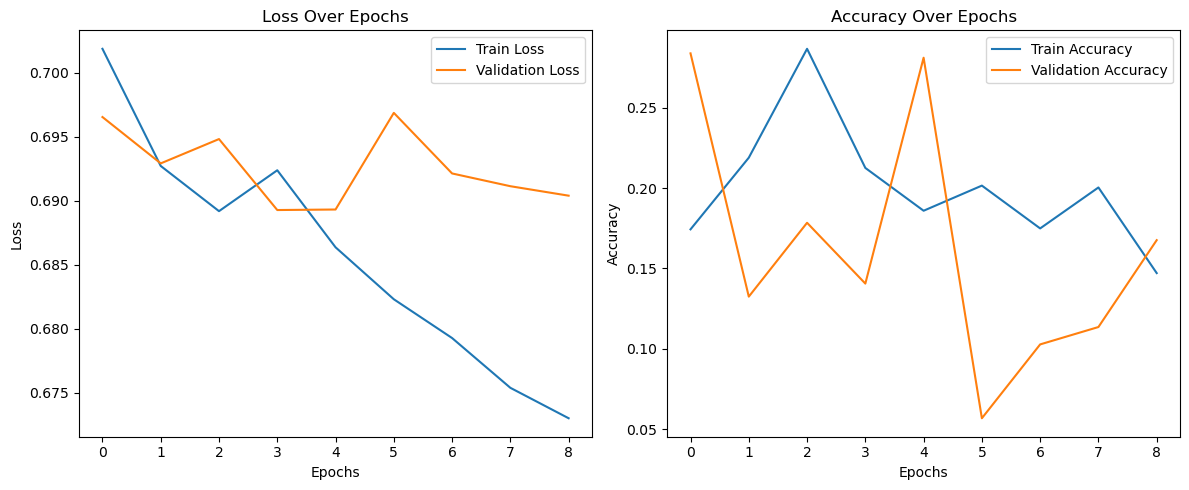

In [31]:
def train_transformer_model(model, X_train, y_train, X_val, y_val, epochs, batch_size):
    """
    Train the transformer model.

    Parameters
    ----------
      - model (keras.src.models.functional.Functional): Compiled model.
      - X_train (numpy.ndarray): Training input sequences.
      - y_train (numpy.ndarray): Training labels.
      - X_val (numpy.ndarray): Validation input sequences.
      - y_val (numpy.ndarray): Validation labels.
      - epochs (int): Number of training epochs.
      - batch_size (int): Batch size for training.

    Returns
    -------
      - history: Training history object.
    """
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6)
    ]
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        batch_size=batch_size,
        epochs=epochs,
        callbacks=callbacks
    )
    print(type(history))
    return history

model_transformer_train_history = train_transformer_model(model_transformer, X_train, y_train, X_val, y_val, 500, 64) # Train Model
plot_training_history(model_transformer_train_history) # Plot train history

# Save the trained model
model_transformer.save("model_transformer.h5")

## Evaluate Model

2025-03-18 23:04:59,690 - INFO - Evaluating model...


12/12 [==============================] - 4s 315ms/step


2025-03-18 23:05:03,657 - INFO - Optimal thresholds for each label: [0.5, 0.5, 0.5, 0.5, 0.5]
2025-03-18 23:05:03,678 - INFO - Total Accuracy: 0.0350, Multilabel Accuracy: 0.5283, Weighted Precision: 0.5460, Weighted Recall: 0.6855, Weighted F1-Score: 0.5590, Micro F1-Score: 0.6046, Macro F1-Score: 0.5645


                   precision    recall  f1-score   support

     Extraversion       0.60      0.81      0.69       213
      Neuroticism       0.54      0.67      0.60       176
    Agreeableness       0.52      0.98      0.68       193
Conscientiousness       0.55      0.13      0.21       211
         Openness       0.51      0.88      0.64       183

        micro avg       0.54      0.69      0.60       976
        macro avg       0.54      0.69      0.56       976
     weighted avg       0.55      0.69      0.56       976
      samples avg       0.54      0.68      0.57       976



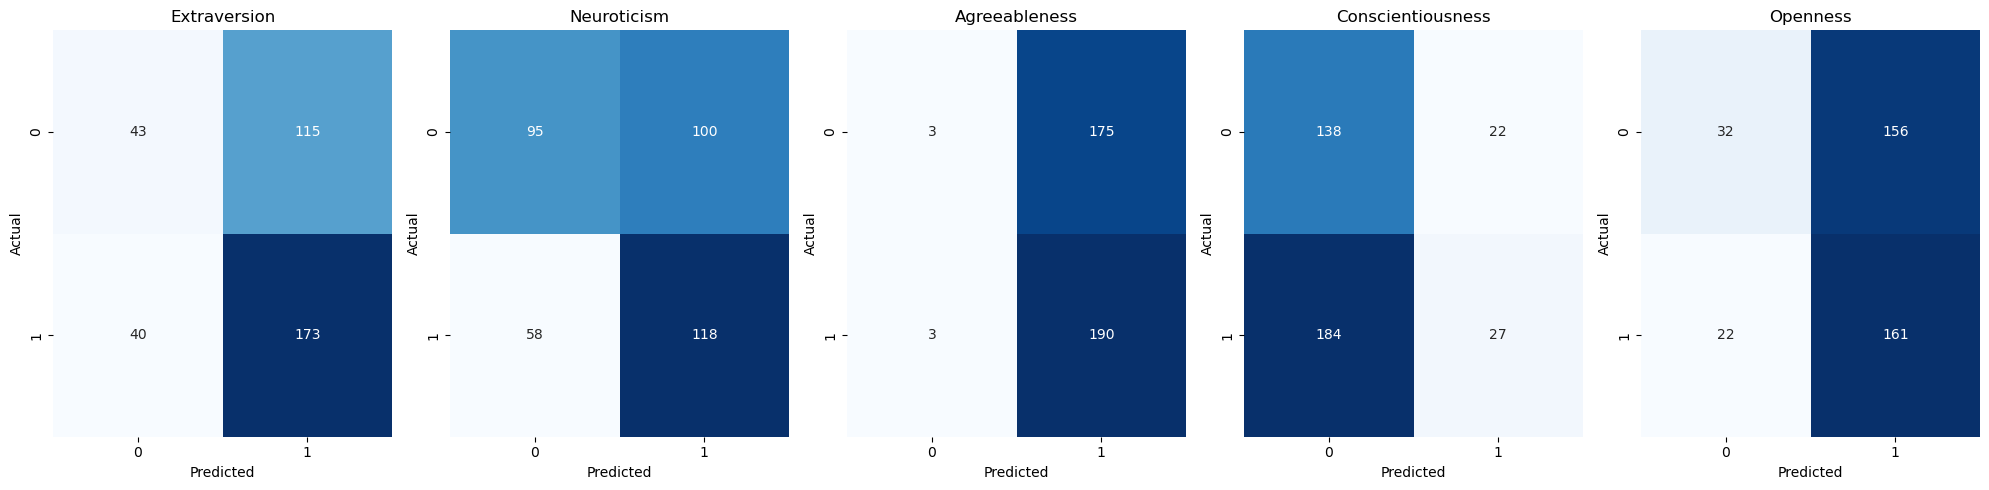

In [33]:
# Load the saved model
model_transformer = load_model("model_transformer.h5")
evaluate_model(model_transformer, X_test, y_test, LABEL_MAPPING.values()) # Evaluate Model